# Linear Regression Practical

In this notebook, we will perform a linear regression analysis on `CO2 Emissions` to understand the drivers for CO2 emissions, that is, we predict the CO2 Emission of a car based on the features of the car.

The steps in the practical include:
* Loading the required libraries
* Reading and exploring the dataset
* Data cleaning
* Exploratory data analysis
* Modelling
* Model evaluation
* ML pipeline
* Cross validation
* Regularization

**The data for this practical was obtained from the IBM cloud storage**.

### Loading the required libraries

In [58]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pylab as plt
%matplotlib inline

from scipy.stats import boxcox
from scipy.stats.mstats import normaltest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import KFold

### Reading and exploring the dataset

In [14]:
# Reading the dataset to a pandas dataframe
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv")
# take a look at the dataset
df.head()

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


Lets explore the dataset a bit

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   MODELYEAR                 1067 non-null   int64  
 1   MAKE                      1067 non-null   object 
 2   MODEL                     1067 non-null   object 
 3   VEHICLECLASS              1067 non-null   object 
 4   ENGINESIZE                1067 non-null   float64
 5   CYLINDERS                 1067 non-null   int64  
 6   TRANSMISSION              1067 non-null   object 
 7   FUELTYPE                  1067 non-null   object 
 8   FUELCONSUMPTION_CITY      1067 non-null   float64
 9   FUELCONSUMPTION_HWY       1067 non-null   float64
 10  FUELCONSUMPTION_COMB      1067 non-null   float64
 11  FUELCONSUMPTION_COMB_MPG  1067 non-null   int64  
 12  CO2EMISSIONS              1067 non-null   int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 108.5+ KB


From the above we have 1067 entries and each column in the dataframe has 1067 non-null value which means there is no missing observation in our data frame. We can also see the various data types for each of features in our data frame.

### Data cleaning

In [16]:
# Checking for missing values
df.isnull().sum()

MODELYEAR                   0
MAKE                        0
MODEL                       0
VEHICLECLASS                0
ENGINESIZE                  0
CYLINDERS                   0
TRANSMISSION                0
FUELTYPE                    0
FUELCONSUMPTION_CITY        0
FUELCONSUMPTION_HWY         0
FUELCONSUMPTION_COMB        0
FUELCONSUMPTION_COMB_MPG    0
CO2EMISSIONS                0
dtype: int64

In [17]:
# dropping columns from the dataframe we don't need for the analysis
df = df.drop(df.columns[[0, 1, 2, 3, 6, 7]], axis=1)
df.head(5)

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2.0,4,9.9,6.7,8.5,33,196
1,2.4,4,11.2,7.7,9.6,29,221
2,1.5,4,6.0,5.8,5.9,48,136
3,3.5,6,12.7,9.1,11.1,25,255
4,3.5,6,12.1,8.7,10.6,27,244


We confirm again there are no missing values in our data frame. Lets proceed with some exploratory analysis

### Exploratory data analysis

In [5]:
# Lets see some statistical information about each features.
df.describe()

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
count,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
mean,3.346298,5.794752,13.296532,9.474602,11.580881,26.441425,256.228679
std,1.415895,1.797447,4.101253,2.794510,3.485595,7.468702,63.372304
min,1.000000,3.000000,4.600000,4.900000,4.700000,11.000000,108.000000
25%,2.000000,4.000000,10.250000,7.500000,9.000000,21.000000,207.000000
50%,3.400000,6.000000,12.600000,8.800000,10.900000,26.000000,251.000000
75%,4.300000,8.000000,15.550000,10.850000,13.350000,31.000000,294.000000
max,8.400000,12.000000,30.200000,20.500000,25.800000,60.000000,488.000000


Recall, that our target variable is the **CO2EMISSIONS**. Now lets the correlation coefficient get glimpse of the relationships the features as well as the target variable. 

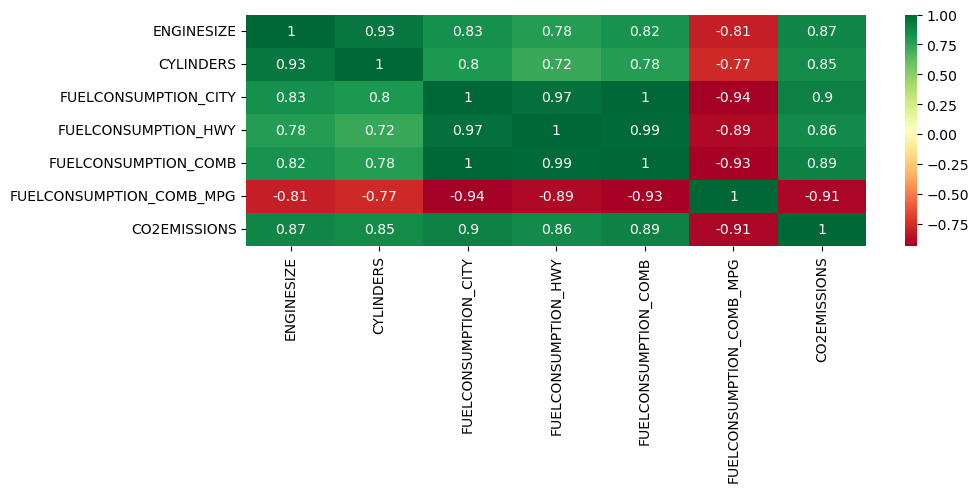

In [18]:
# plot of the correlation matrix with heatmap
plt.figure(figsize=(10,3))
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn')

plt.show()

In [19]:
# Correlation of the features with respect to the CO2 Emissions
corr_matrix = df.corr()
corr_matrix['CO2EMISSIONS'].sort_values(ascending=False)

CO2EMISSIONS                1.000000
FUELCONSUMPTION_CITY        0.898039
FUELCONSUMPTION_COMB        0.892129
ENGINESIZE                  0.874154
FUELCONSUMPTION_HWY         0.861748
CYLINDERS                   0.849685
FUELCONSUMPTION_COMB_MPG   -0.906394
Name: CO2EMISSIONS, dtype: float64

In [21]:
# lets see all the features
df.columns

Index(['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_CITY',
       'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB',
       'FUELCONSUMPTION_COMB_MPG', 'CO2EMISSIONS'],
      dtype='object')

Lets visualize this relationships, we can do this individually using a scatter plot or combined using a pair plot.

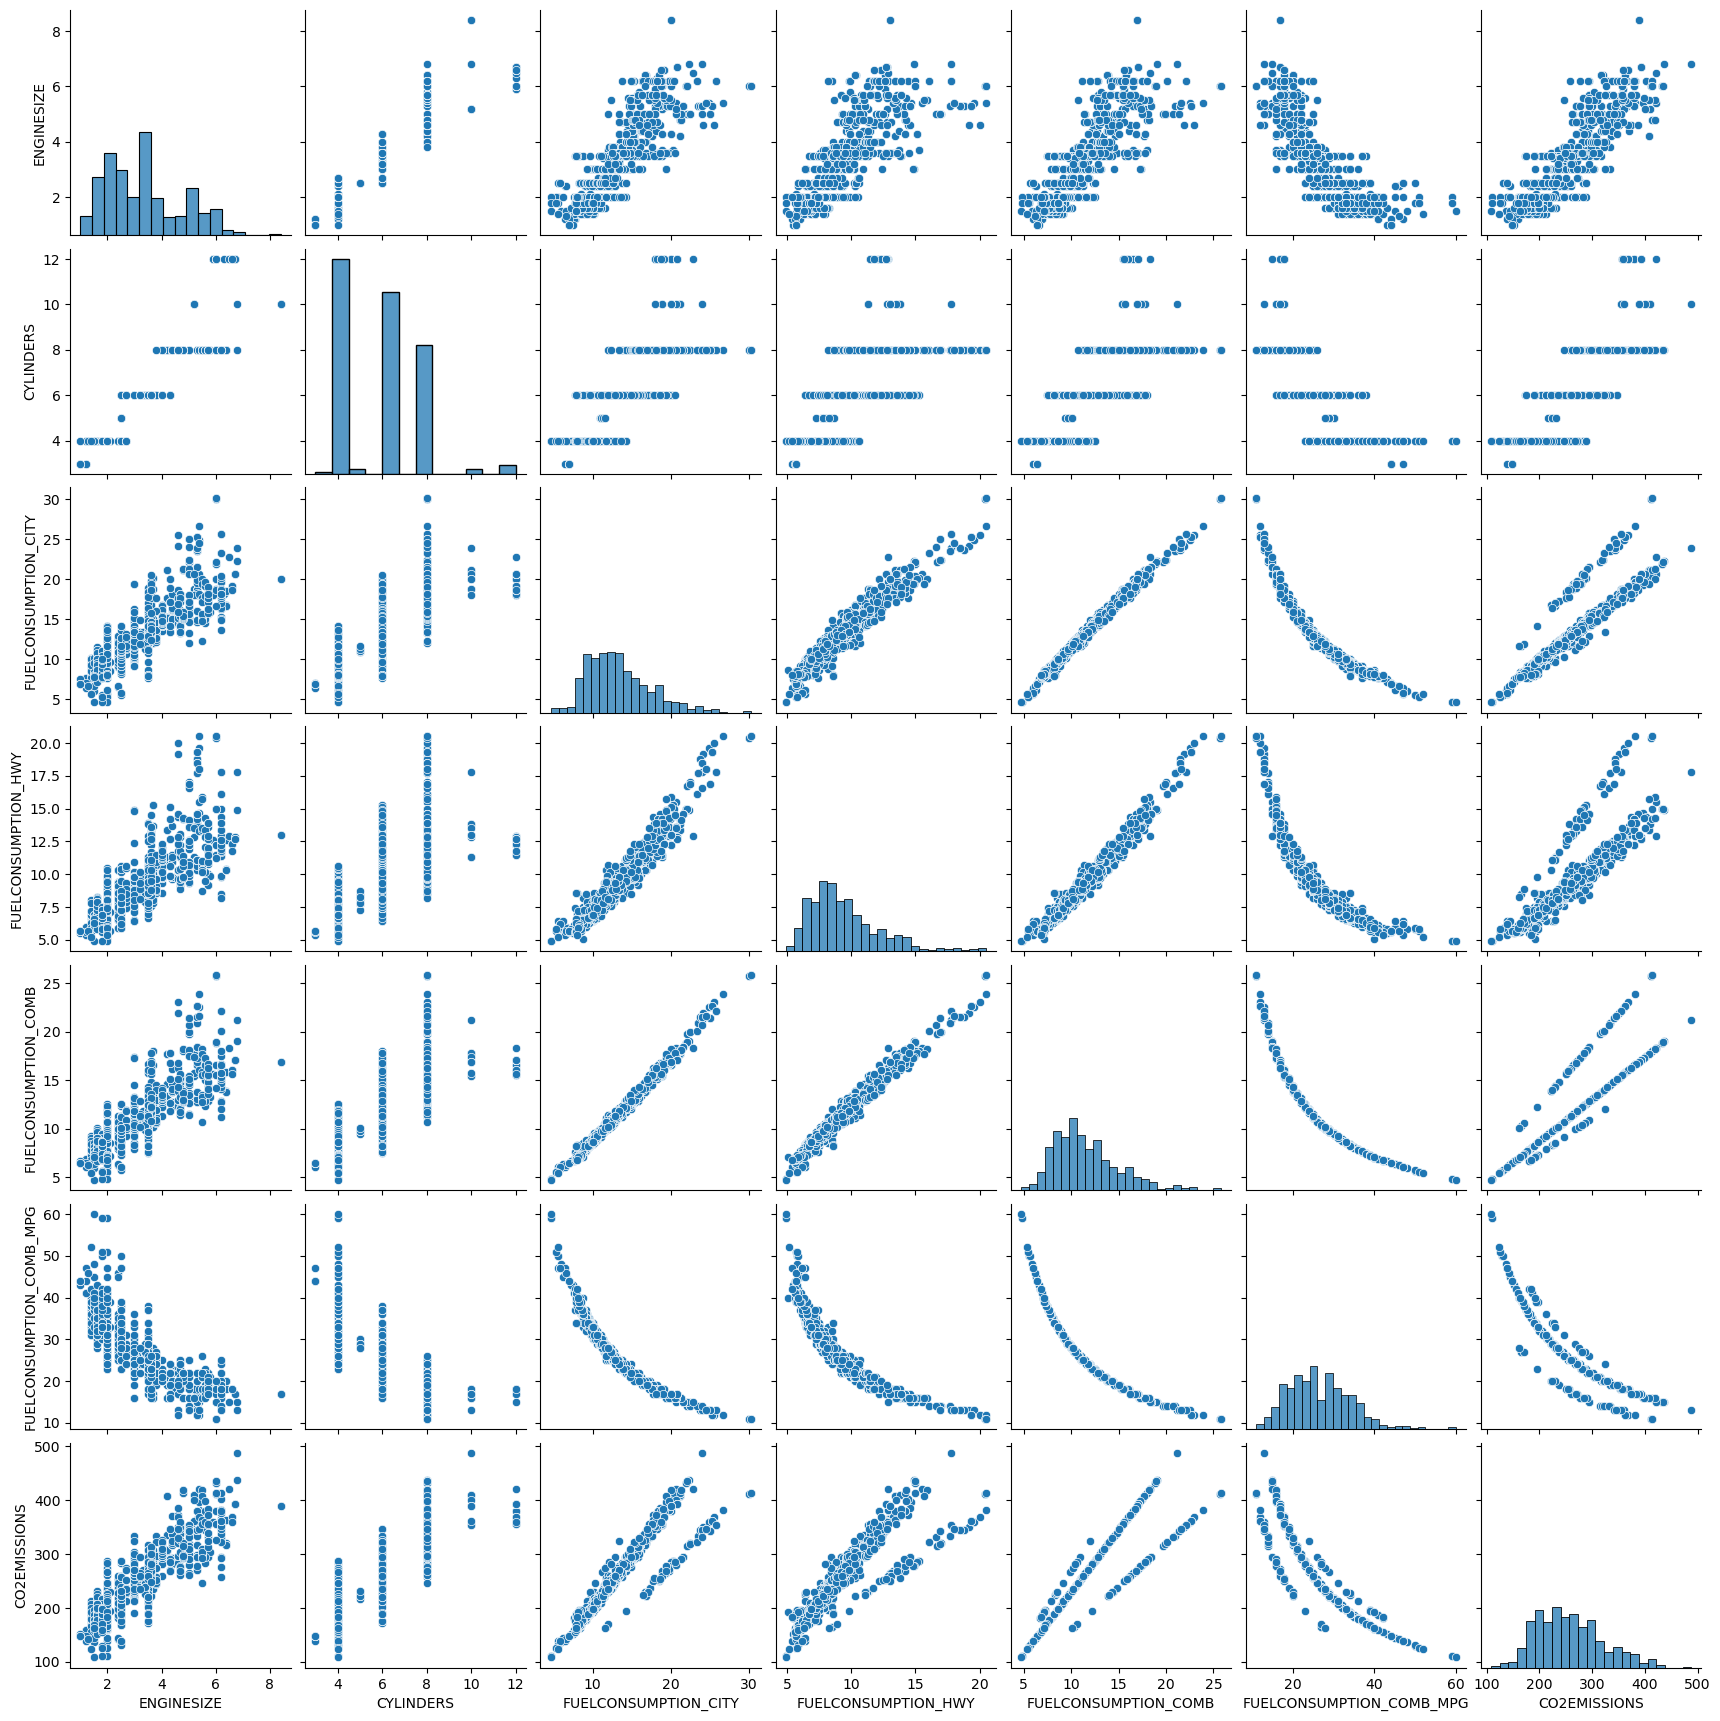

In [20]:
# pairplot of our features
sns.pairplot(df) 
plt.show()

**Note**: some of the important assumption of linear regression is a *linear relationship* between the target and the features and *normality* of the residuals of the model.  

From the pairplot above, in the last row, notice that both their exist some linear relationships between the features and the target variable(CO2EMISSIONS). 

Next, we plot the histogram of the residual to indeed show the model is somewhat normally distributed. This can be observed in the output below.

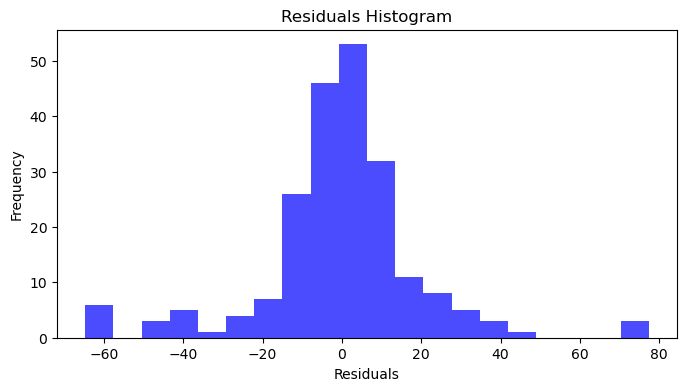

In [25]:
X = df[['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_CITY',
       'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB',
       'FUELCONSUMPTION_COMB_MPG']]  # Replace with your actual independent variables
y = df['CO2EMISSIONS']  # Replace with your actual target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate residuals on the test set
residuals = y_test - model.predict(X_test)

# Create a histogram of residuals
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=20, color='blue', alpha=0.7)
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

**Data transformation and standardization**

While often it is important to standardize the features and ensure they all the same scale, we skip that in this practical since all the features are of the same scale, that would not be necessary.

Also, since the residual of our model is normally distributed, it also would be necessary for us to do any sort of data transformation on our variables.

### Modelling

In [27]:
# Recall our variables and data
X = df.drop("CO2EMISSIONS", axis=1)
y = df["CO2EMISSIONS"].copy()

# Creating the test and train sets form the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# To check the shape of the testing and training test
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


Train set: (800, 6) (800,)
Test set: (267, 6) (267,)


In [28]:
# Applying the linear regression and fitting it to the data
l_model = LinearRegression()
l_model.fit(X_train,y_train)

# the coefficients of the model
print ('Coefficients: ', l_model.coef_)
print ('Intercept: ',l_model.intercept_)

Coefficients:  [  9.11620372   8.0865686  -14.88317428  -6.32133311  24.61527912
  -3.93008501]
Intercept:  256.2726526113796


Now lets make the prediction with the model

In [30]:
# Getting the predicted values for CO2EMISSION with the model
CO2EMISSIONS_predictions = l_model.predict(X_test)
CO2EMISSIONS_predictions[0:5]

array([340.57102336, 210.24515898, 224.47297525, 228.00591703,
       177.22549746])

### Model evaluation

We can check the performance of the model using the R-squared and the mean squared error as shown below.

In [31]:
print(r2_score(y_test, CO2EMISSIONS_predictions))
print(mean_squared_error(y_test, CO2EMISSIONS_predictions))

0.8878999209669733
456.8558249648375


### Pipeline

For all the steps we've implemented, we can create an **ML pipeline** to automate aLL the steps involved in the model from training to modelling to evaluation. This can be shown below, but unlike before, we apply a normalizer to the features. Notice we still get the same results.

In [35]:
steps=[('norm', Normalizer()), ('l_model',  LinearRegression())]
pipe = Pipeline(steps=steps)
pipe.fit(X_train,y_train)
CO2EMISSIONS_predictions = pipe.predict(X_test)
print(r2_score(y_test, CO2EMISSIONS_predictions))
print(mean_squared_error(y_test, CO2EMISSIONS_predictions))

0.8875490560993075
458.28574954608126


We can also just do a **simple linear regression** for all the features and see the feature with the highest R-squared

In [38]:
R2=[]
pipe = Pipeline([('l_mod', LinearRegression())])

for x in X:
    pipe.fit(X_train[[x]],y_train)
    R2.append(pipe.score(X_train[[x]],y_train))
R2    

[0.7769800597617792,
 0.7290088547688934,
 0.802559285687229,
 0.7373308284194501,
 0.7913437705128004,
 0.8222854084352963]

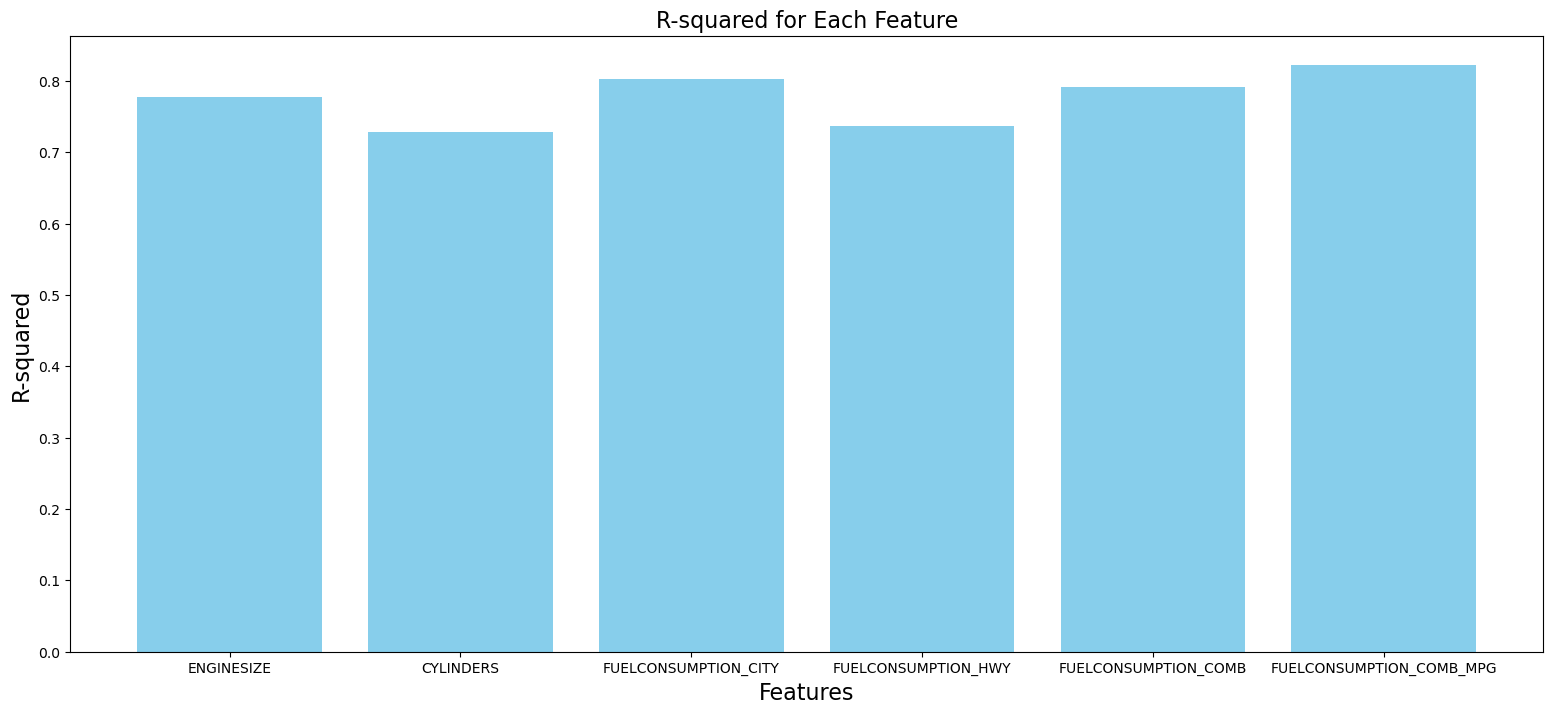

In [54]:
# Let make define the list of features.
X_features =['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_CITY',
       'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB',
       'FUELCONSUMPTION_COMB_MPG']
# Create a bar plot
plt.figure(figsize=(19, 8))
plt.bar(X_features, R2, color='skyblue')
plt.xlabel('Features', fontsize=16)
plt.ylabel('R-squared', fontsize=16)
plt.title('R-squared for Each Feature', fontsize=16)
plt.show()

From the analysis above, we can see that the feature *FUELCONSUMPTION_COMB_MPG*, fuel consumption miles per gallon has the highest R-squared.

### Cross validation

This is just a simple multiple regression on pairs of train/test split, then averaging the resulting errors for each pairs for use in model evaluation.

We can simple just extend our pipeline to include cross validation.

In [62]:
n_splits = 3
Cross_val = KFold(3)

R2=np.zeros((3,1))
pipe = Pipeline([('l_model', LinearRegression())])
n=0    
X_train, X_test =X.iloc[train_index],X.iloc[test_index]   
y_train, y_test=y[train_index],y[test_index]
pipe.fit(X_train,y_train)
n=+1
R2[k]=pipe.score(X_test, y_test)
    
    
R2.mean()

0.3071162901329506

### Regularization

Often, it is possible that the regression model will overfit the dataset. One way to avoid this overfitting is through regularization. This is simply fine tunning the regression model. Basically, it means shrinking the coefficient estimates towards zero to avoid overfitting i.e, reducing the magnitude of the variables. Regularization does this by adding a penalty to the cost function of the regression model. Three main regularization techniques are LASSO, RIDGE, ELASTIC NET.

This will be covered in later practicals.

### Thank you for following till the end.